In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import glob as glob
import os as os
import ot
from scipy.stats import skew
import seaborn as sb
import geochron as geochron
from scipy.stats import ks_2samp
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors
from matplotlib import cm
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
import matplotlib.patheffects as pe
import warnings
np.random.seed(0) # Set seed
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def calc_flatness(ages, gradient_cut_off = 0.3, young_index = 2):
    
    # ages is an array of the unnormalised age distribution
    # threshold is the gradient of an ECDF below which inheritance is marked
    # f_threshold is the maximum relative age below the threshold which is deemed acceptable for an age distribution
    # young_index is the index from which look at the gradient of the ECDF (to avoid younger outliers)   
    x = np.sort((ages - np.min(ages)) / (np.max(ages) - np.min(ages))) 
    y = np.linspace(0, 1, len(x), endpoint=False)
    dx = np.gradient(x)
    dy = np.gradient(y)
    gradient_ecdf = dy/dx
    gradient_ecdf = gradient_ecdf[young_index:] # Exclude the gradient of the youngest part of the curve
    flatness = np.sum(np.diff(x[young_index:][np.argwhere(gradient_ecdf<gradient_cut_off)].flatten()))
    
    return flatness

def filter_older_ages(age_dist, unc, gradient_cut_off = 0.3, young_index = 2, tflatmax = 0.25):
    while calc_flatness(age_dist, gradient_cut_off = gradient_cut_off, young_index = young_index) >= tflatmax:
        age_dist = age_dist[:-1]
        unc = unc[:-1]
    
    return(age_dist,unc)

def plot_kde(ages, uncertainty=None, normalize = False):
    if normalize is True:
        ages = (ages - np.min(ages)) / (np.max(ages) - np.min(ages))
    if uncertainty is None:
        kde = stats.gaussian_kde(ages)
    else:
        weights = (1/uncertainty**2)/np.sum(1/uncertainty**2)
        kde = stats.gaussian_kde(ages, weights = weights)
    bw = kde.covariance_factor()*np.std(ages) # extract bw
    # eval_points = np.linspace(np.min(ages)-0.05, np.max(ages)+bw)
    eval_points = np.linspace(np.min(ages), np.max(ages))
    y_sp = kde.pdf(eval_points)
    return(eval_points, y_sp)

def normalize_age(group):
    min_age = group.min()
    max_age = group.max()
    return (group - min_age) / (max_age - min_age)

def ecdf(ages, uncertainties=None):
    
    # Normalize the data between 0 and 1
    data_min = min(ages)
    data_max = max(ages)
    normalized_data = (ages - data_min) / (data_max - data_min)

    # Sort the data and weights accordingly
    sorted_indices = np.argsort(normalized_data)
    sorted_data = np.array(normalized_data)[sorted_indices]
    
    if uncertainties is None:
        weights = np.ones(len(ages))
    else:
        weights = (1/uncertainties**2)/np.sum(1/uncertainties**2)
        weights = np.array(weights)[sorted_indices]
    
    # Compute the weighted ECDF
    weighted_cumsum = np.cumsum(weights)
    ecdf_y = weighted_cumsum / weighted_cumsum[-1]
    
    return(sorted_data, ecdf_y)

def check_data(ages, unc):
    if len(ages) < 10:
        warnings.warn("Distributions with low number of dates may not provide useful results")
    delta_T = np.max(ages) - np.min(ages)
    avg_sigma = np.mean(unc)
    if delta_T/avg_sigma < 10:
        warnings.warn("Distributions with low ΔT/σ may not provide useful results")
    if np.mean(ages) > 120:
        warnings.warn("Age distributions greater than 120 Ma may not provide useful results, check for Pb loss")

    
        
def calc_W_PCA(ages, unc):
    check_data(ages, unc)
    data = pd.read_csv('/Users/cnathwani/Desktop/Python_Projects/zircon_age_spectra/data/zircon_tims_comp_filtered.csv')
    localities = [data.groupby('Locality').get_group(x) for x in data.groupby('Locality').groups]

    all_samples = []

    mapper = pd.Series(data.Locality.values,index=data.Unit).to_dict()
    mapper2 = pd.Series(data.Type.values,index=data.Unit).to_dict()

    ws = []
    dic = {}
    count = 0
    for n,locality in enumerate(localities):
        name = locality['Unit'].unique()
        units = [locality.groupby('Unit').get_group(x) for x in locality.groupby('Unit').groups]
        for unit in units:
            all_samples.append(name)
            # s, p = stats.skewtest(unit['age68'])
            sample_name = unit['Unit'].iloc[0]
            unit = unit.drop(['Unit'], axis = 1)
            dic[sample_name] = unit
            count = count + 1


    values = dic.values()
    keys = list(dic.keys())


    for df in values:
        for i in np.arange(0,len(values)):
            df2 = list(values)[i]
            # Calculate Wasserstein metric
            w2 = geochron.calc_w2(df['age68'],df2['age68'],x_err = df['2s_68'], y_err = df2['2s_68'], normalize = True)
            ws.append(w2)


    ws = np.array(ws).reshape(len(values), len(values))


    PCA_ws = PCA(n_components = 2)

    names = [*map(mapper.get, keys)]
    types = [*map(mapper2.get, keys)]

    types = pd.Series(types, name = 'Type')
    names = pd.Series(names, name = 'Locality')

    PC_scores = pd.DataFrame(PCA_ws.fit_transform(ws), columns = ['PC1','PC2'])
    PC_scores['Type'] = types
    PC_scores['Locality'] = names

    pca_types = [PC_scores.groupby('Type').get_group(x) for x in PC_scores.groupby('Type').groups]


    w2_user = []
    for i in np.arange(0,len(values)):
        df2 = list(values)[i]
        w2 = geochron.calc_w2(ages,df2['age68'],x_err = unc, y_err = df2['2s_68'], normalize = True)
        w2_user.append(w2)
    pc_user = PCA_ws.transform(X = np.array(w2_user).reshape(1, -1)).flatten()
    return(pc_user)


## 1. Insert your data here

In [3]:
# Insert ages here
ages = [0.151, 0.284, 0.293, 0.195, 0.237, 0.21 , 0.367, 0.546, 0.941,
       0.194, 0.422, 0.219, 0.29 , 0.242, 0.319, 0.269, 0.267, 0.138,
       0.217, 0.327, 0.206, 0.263, 0.359, 0.303, 0.449, 0.138, 0.365,
       0.261, 0.142]

# Insert uncertainties here 2s
unc = [0.006, 0.005, 0.005, 0.007, 0.006, 0.005, 0.004, 0.006, 0.005,
       0.005, 0.005, 0.006, 0.005, 0.006, 0.005, 0.005, 0.005, 0.007,
       0.006, 0.005, 0.007, 0.006, 0.01 , 0.005, 0.015, 0.01 , 0.008,
       0.007, 0.006]

# ages = [315.24, 314.29, 333.46, 328.50, 333.95, 332.43, 334.20]
# unc = [0.65,16.0,0.86,1.35,6.48,1.15,0.35]


## 2. Filter the dataset

/Users/cnathwani/Desktop/Python_Projects/zircon_age_spectra/scripts/geochron.py:107: RuntimeWarning: divide by zero encountered in true_divide
  gradient_ecdf = dy/dx


Filtered ages: [0.449 0.546 0.941]


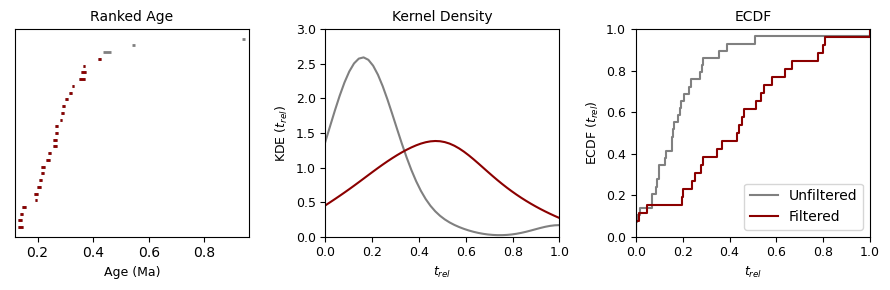

In [4]:
ages = np.array(ages)
ind = ages.argsort()
ages = ages[ind]
unc = np.array(unc)[ind]

ages_fil, unc_fil = geochron.filter_older_ages(age_dist=ages,unc=unc, weighted = False)

print('Filtered ages:', str(np.setdiff1d(ages, ages_fil)))



fig, axs = plt.subplots(1,3, figsize = (9,3))

axs[0].hlines(y = range(len(ages)), xmin =  ages-unc, 
                     xmax = ages+unc, linewidth = 2, color = 'gray')

axs[0].hlines(y = range(len(ages_fil)), xmin =  ages_fil-unc_fil, 
                     xmax = ages_fil+unc_fil, linewidth = 2, color = 'darkred')


# unfiltered
ages_kde = geochron.plot_kde(ages,unc, normalize = True)
axs[1].plot(ages_kde[0],ages_kde[1], color = 'gray', label = 'Unfiltered')
axs[2].step(ecdf(ages)[0], ecdf(ages)[1], where = 'post', label = 'Unfiltered', c = 'gray')

# filtered

ages_kde = geochron.plot_kde(ages_fil, unc_fil, normalize = True)
axs[1].plot(ages_kde[0],ages_kde[1], color = 'darkred', label = 'Filtered')
axs[2].step(geochron.ecdf(ages_fil)[0], geochron.ecdf(ages_fil)[1], where = 'post', label = 'Filtered', c = 'darkred')

axs[0].set_xlabel('Age (Ma)', fontsize = 9)

axs[0].set_yticks([])
axs[0].set_xlim(np.min(ages)-0.02,np.max(ages)+0.02)


axs[1].set_ylabel('KDE ($t_{rel}$)', fontsize = 9)
axs[1].set_xlabel('$t_{rel}$', fontsize = 9)

axs[2].set_ylabel('ECDF ($t_{rel}$)', fontsize = 9)
axs[2].set_xlabel('$t_{rel}$', fontsize = 9)

axs[1].set_xlim([0,1])
axs[1].set_ylim([0,3.0])
axs[2].set_xlim([0,1])
axs[2].set_ylim([0,1])

axs[1].xaxis.set_tick_params(labelsize = 9)
axs[2].xaxis.set_tick_params(labelsize = 9)
axs[0].yaxis.set_tick_params(labelsize = 9)
axs[1].yaxis.set_tick_params(labelsize = 9)
axs[2].yaxis.set_tick_params(labelsize = 9)

axs[0].set_title('Ranked Age', fontsize = 10)
axs[1].set_title('Kernel Density', fontsize = 10)
axs[2].set_title('ECDF', fontsize = 10)

axs[2].legend()

plt.tight_layout()
plt.show()

In [5]:
ages_fil

array([0.138, 0.138, 0.142, 0.151, 0.194, 0.195, 0.206, 0.21 , 0.217,
       0.219, 0.237, 0.242, 0.261, 0.263, 0.267, 0.269, 0.284, 0.29 ,
       0.293, 0.303, 0.319, 0.327, 0.359, 0.365, 0.367, 0.422])

In [6]:
unc_fil

array([0.01 , 0.007, 0.006, 0.006, 0.005, 0.007, 0.007, 0.005, 0.006,
       0.006, 0.006, 0.006, 0.007, 0.006, 0.005, 0.005, 0.005, 0.005,
       0.005, 0.005, 0.005, 0.005, 0.01 , 0.008, 0.004, 0.005])

## 3. See where your data plots relative to other age distributions

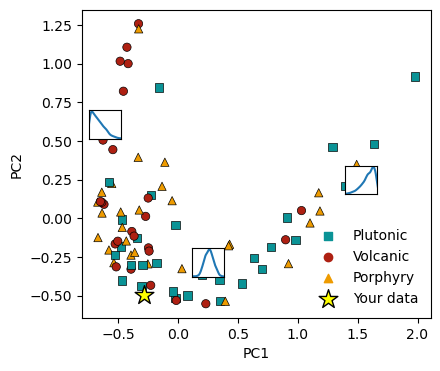

In [7]:
fig, axs = plt.subplots(1,1, figsize = (4.5,4))

colors = [(10/255, 147/255, 150/255),(174/255, 32/255, 18/255),(238/255, 155/255, 0/255)]
shapes = ['s','o','^']

pc1, pc2, types = geochron.generate_pca_scores()

sb.scatterplot(x=pc1,y=pc2,hue = types, style = types,
              edgecolor = 'black', palette = colors, markers = shapes, ax = axs)

axs.set_xlabel('PC1')
axs.set_ylabel('PC2')

numValues = 1000
maxValue = 1
skewness = -10   #Negative values are left skewed, positive values are right skewed.

size_x = 0.27
size_y = 0.185

example_skews = [-100,0,100]

for skew in example_skews:
    x = stats.skewnorm.rvs(a = skew,loc=maxValue, size=numValues)  #Skewnorm function
    x = x - min(x)      #Shift the set so the minimum value is equal to zero.
    x = x / max(x)      #Standadize all the vlues between 0 and 1. 
    x = x * maxValue         #Multiply the standardized values by the maximum value.
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pc1, pc2 = geochron.calc_W_PCA(x, np.ones(len(x)))
    
    ax = inset_axes(axs, "100%", "100%", 
                    bbox_to_anchor=(pc1-(size_x/2), pc2-(size_y/2), size_x, size_y),
                    bbox_transform=axs.transData, loc="center")
    
    sb.kdeplot(x, ax = ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xlim([0,1])

x = np.linspace(0,1,10000)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

pc1, pc2 = geochron.calc_W_PCA(ages_fil, unc_fil)

axs.scatter(pc1, pc2, s = 200, color = 'yellow', marker = '*', edgecolor = 'black', label = 'Your data')

legend = axs.legend(loc = 4, frameon = False)
plt.rcParams['svg.fonttype'] = 'none'
plt.show()

(0    -0.465769
 1    -0.391456
 2    -0.667256
 3    -0.464677
 4    -0.534635
         ...   
 79   -0.502114
 80   -0.515172
 81   -0.647220
 82   -0.366053
 83   -0.425625
 Name: PC1, Length: 84, dtype: float64,
 0    -0.007005
 1    -0.328376
 2    -0.124333
 3    -0.058656
 4    -0.286713
         ...   
 79   -0.147986
 80   -0.313683
 81    0.107973
 82   -0.115072
 83    1.105376
 Name: PC2, Length: 84, dtype: float64,
 0     Plutonic
 1     Volcanic
 2     Porphyry
 3     Porphyry
 4     Porphyry
         ...   
 79    Volcanic
 80    Volcanic
 81    Volcanic
 82    Volcanic
 83    Volcanic
 Name: Type, Length: 84, dtype: object)

In [2]:
dir(geochron)

['PCA',
 'TIMS_func',
 'TIMS_pcov',
 'TIMS_popt',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'calc_W_PCA',
 'calc_delT',
 'calc_flatness',
 'calc_w2',
 'curve_fit',
 'ecdf',
 'filter_older_ages',
 'generate_pca_scores',
 'laser',
 'laser_func',
 'laser_func_unc',
 'laser_pcov',
 'laser_popt',
 'normalize_age',
 'np',
 'ot',
 'pd',
 'plot_kde',
 'sava',
 'stats',
 'tims_func_unc']